# Game of 24

In [1]:
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def get_files_in_folder(folder_path):
    files = []
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            files.append(folder_path + "/" +file)
    return files

def get_number(string):
    numbers = re.findall(r'\d+', string)
    numbers = list(map(int, numbers))
    return numbers[0] 
    
def get_params(file_path):
    data = {}

    file_name = file_path.split('/')[-1]
    params = file_name.split('_')

    data["set"] = params[0].split("-")[0]
    data["n_agents"] = get_number(params[1])
    data["n_steps"] = get_number(params[2])
    data["k"] = get_number(params[3])
    data["origin_value"] = get_number(params[4])
    data["backtrack"] = float("0." + str(get_number(params[5].split(".")[1])))
    data["resampling"] = params[6].split("-")[0]

    with open(file_path, 'r') as file:
        results = json.load(file)

    data["cost"] = results.pop("Cost")
    success = 0
    for experiment in results.values():
        if {"r":1} in experiment["Verifications"]:
            success +=1
    success_rate  = success/len(results)

    data["success_rate"] = success_rate

    return data

In [3]:
# Accuracy and Cost from ToT benchmarks
tot_runs = get_files_in_folder("benchmarks/gameof24")
accuracies = []
costs = []

for run_file in tot_runs:
    with open(run_file, 'r') as file:
        run = json.load(file)

    # Compute cost
    cost = run[-1]["usage_so_far"]["cost"]
    costs.append(cost)

    # Compute accuracy
    success = 0
    for puzzle in run:
        if {"r":1} in puzzle["infos"]:
            success +=1
    accuracy = success/len(run)
    accuracies.append(accuracy)

tot_cost = sum(costs)/len(costs)
tot_accuracy = sum(accuracies)/len(accuracies)

print(f"Costs :      {[round(cost,2) for cost in costs]}\t->\tMean: {tot_cost:.3f}")
print(f"Accuracies : {[round(accuracy,2) for accuracy in accuracies]}\t->\tMean: {tot_accuracy:.3f}")

Costs :      [1.76, 1.6, 1.77, 1.73, 1.7]	->	Mean: 1.711
Accuracies : [0.25, 0.0, 0.23, 0.2, 0.0]	->	Mean: 0.136


In [4]:
files = get_files_in_folder("logs/test/gameof24")

results = [get_params(file) for file in files]
results = sorted(results, key=lambda x: x["success_rate"], reverse=True)

df = pd.DataFrame(results)
df["input_tokens"] = df["cost"].apply(lambda x: x["input_tokens"])
df["output_tokens"] = df["cost"].apply(lambda x: x["output_tokens"])
df["total_cost"] = df["cost"].apply(lambda x: x["total_cost"])
df["name"] = df.apply(lambda x: f"{x['n_agents']}agents\n{x['n_steps']}steps\n{x['k']}k\n{x['backtrack']}b", axis=1)

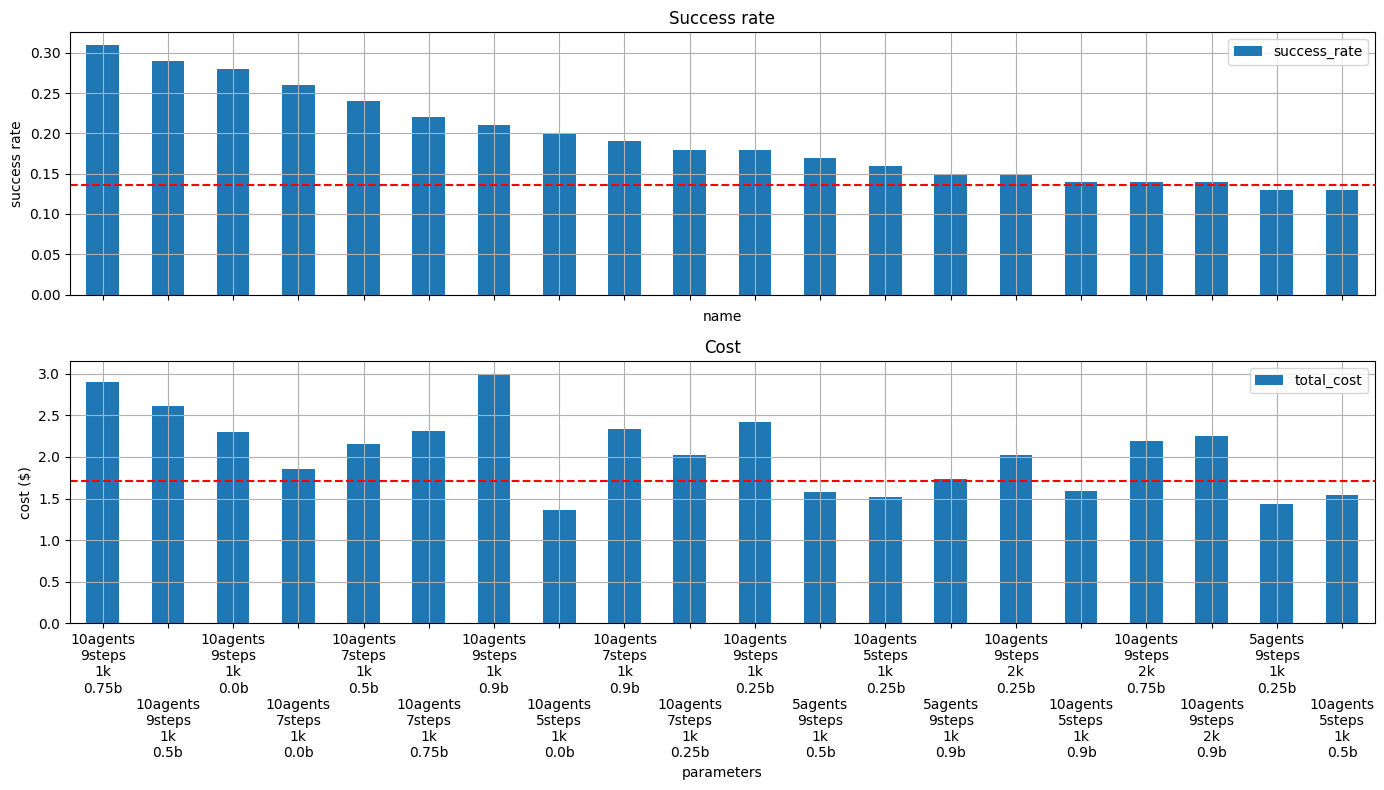

In [5]:
# prioritizing cost

import matplotlib.pyplot as plt

df_temp = df.copy()
df_temp.sort_values(by=["success_rate", "total_cost"], ascending=[False, True], inplace=True)
df_temp = df_temp.head(20)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot the first dataset on the first subplot
df_temp.plot(x="name", y="success_rate", kind="bar", title="Success Rate", ax=ax1)
ax1.axhline(y=tot_accuracy, color='r', linestyle='--')  # Adding a horizontal line
ax1.set_ylabel('success rate')
ax1.set_title('Success rate')
ax1.grid(True)
ax1.set_xticklabels([])  # Hide x-axis tick labels

# Plot the second dataset on the second subplot
df_temp.plot(x="name", y="total_cost", kind="bar", title="Cost", ax=ax2)
ax2.axhline(y=tot_cost, color='r', linestyle='--')  # Adding a horizontal line
ax2.set_xlabel('parameters')
ax2.set_ylabel('cost ($)')
ax2.set_title('Cost')

labels  = df_temp["name"].tolist()
labels = [label if i%2==0 else "\n\n\n\n"+label for i, label in enumerate(labels)]
ax2.set_xticklabels(labels, rotation=0) 
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


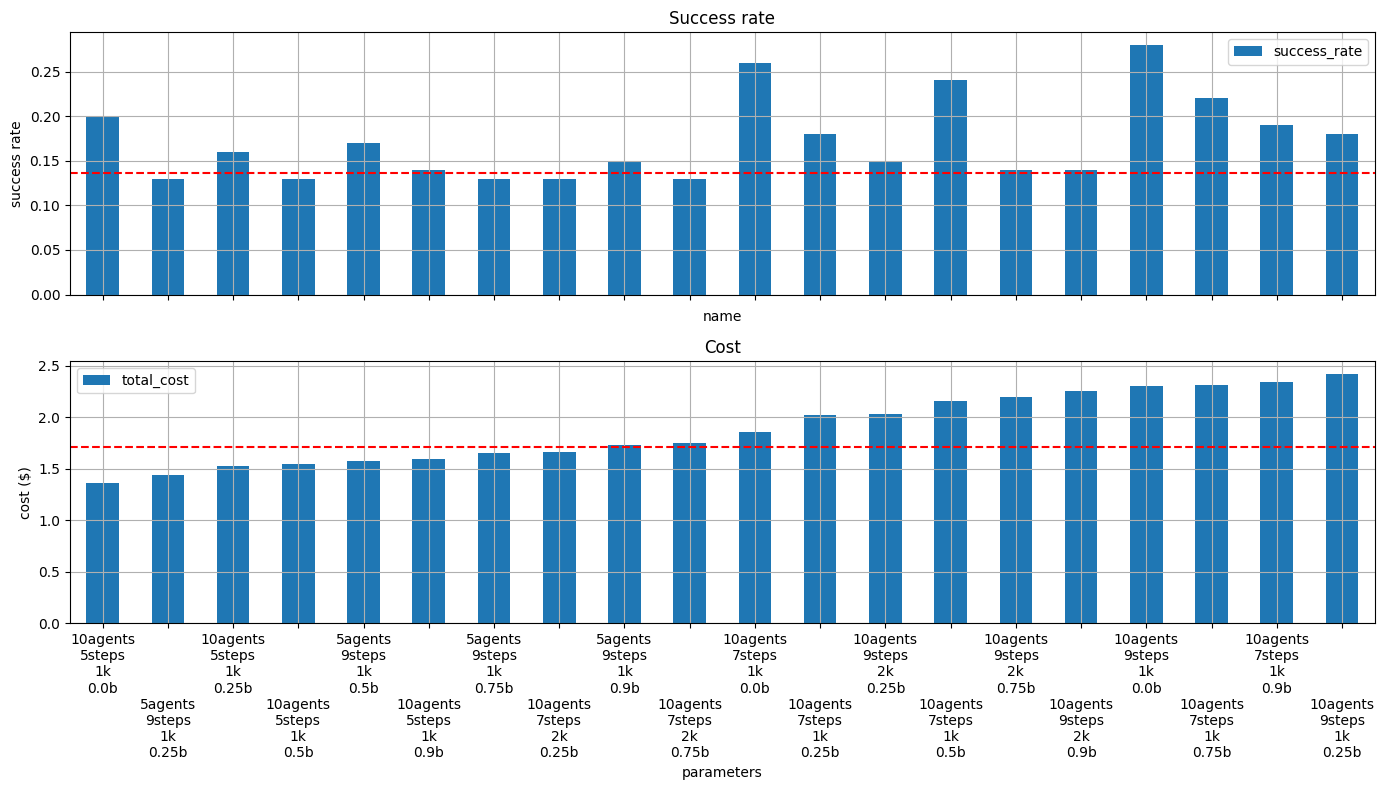

In [6]:
# prioritizing cost

import matplotlib.pyplot as plt

df_temp = df.copy()
df_temp = df_temp[df_temp.success_rate > 0.12]
df_temp.sort_values(by=["total_cost", "success_rate"], ascending=[True, False], inplace=True)
df_temp = df_temp.head(20)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot the first dataset on the first subplot
df_temp.plot(x="name", y="success_rate", kind="bar", title="Success Rate", ax=ax1)
ax1.axhline(y=tot_accuracy, color='r', linestyle='--')  # Adding a horizontal line
ax1.set_ylabel('success rate')
ax1.set_title('Success rate')
ax1.grid(True)
ax1.set_xticklabels([])  # Hide x-axis tick labels

# Plot the second dataset on the second subplot
df_temp.plot(x="name", y="total_cost", kind="bar", title="Cost", ax=ax2)
ax2.axhline(y=tot_cost, color='r', linestyle='--')  # Adding a horizontal line
ax2.set_xlabel('parameters')
ax2.set_ylabel('cost ($)')
ax2.set_title('Cost')
labels  = df_temp["name"].tolist()
labels = [label if i%2==0 else "\n\n\n\n"+label for i, label in enumerate(labels)]
ax2.set_xticklabels(labels, rotation=0) 
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Cost estimation

Estimating the cost of a similar grid search using GPT4

In [7]:


total_cost = df["total_cost"].sum()
print(f"Total cost: {total_cost:.2f}$")

actual_cost = 17.42
print(f"Actual cost: {actual_cost:.2f}$")

total_input_tokens = df["input_tokens"].sum()
total_output_tokens = df["output_tokens"].sum()

cache_cost_conversion = actual_cost/total_cost

converted_total_input_tokens = total_input_tokens*cache_cost_conversion
converted_total_output_tokens = total_output_tokens*cache_cost_conversion
converted_computed_cost_gpt4 = converted_total_input_tokens/1000000*30 + converted_total_output_tokens/1000000*60
converted_computed_cost_gpt4turbo = converted_total_input_tokens/1000000*10 + converted_total_output_tokens/1000000*30

print(f"Converted computed cost GPT4: {converted_computed_cost_gpt4:.2f}$")
print(f"Converted computed cost GPT4 Turbo: {converted_computed_cost_gpt4turbo:.2f}$")



Total cost: 154.65$
Actual cost: 17.42$
Converted computed cost GPT4: 850.62$
Converted computed cost GPT4 Turbo: 348.40$


# Confidence intervals

Idea: The parameter with the wide confidence intervals influence the least the success rate.

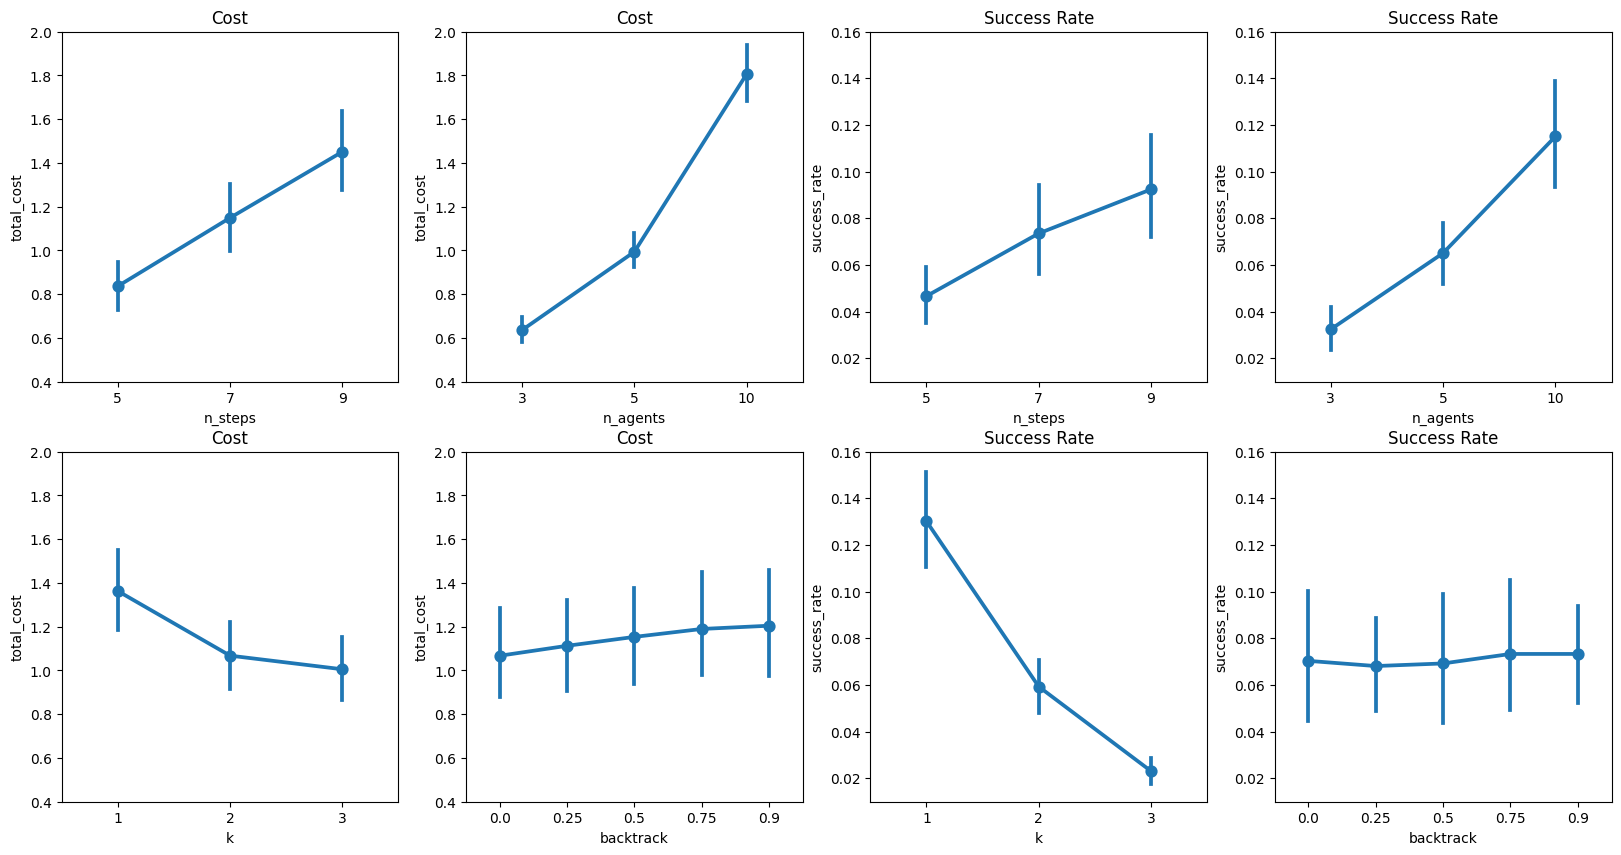

In [29]:
import seaborn as sns

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
sns.pointplot(x="n_steps", y="total_cost", ax=axes[0,0], data=df)
sns.pointplot(x="n_agents", y="total_cost", ax=axes[0,1], data=df)
sns.pointplot(x="k", y="total_cost", ax=axes[1,0], data=df)
sns.pointplot(x="backtrack", y="total_cost", ax=axes[1,1], data=df)

sns.pointplot(x="n_steps", y="success_rate", ax=axes[0,2], data=df)
sns.pointplot(x="n_agents", y="success_rate", ax=axes[0,3], data=df)
sns.pointplot(x="k", y="success_rate", ax=axes[1,2], data=df)
sns.pointplot(x="backtrack", y="success_rate", ax=axes[1,3], data=df)

for i in range(2):
    for j in range(2):
        axes[i,j].set_ylim(0.4, 2)
        axes[i,j].set_title("Cost")

for i in range(2):
    for j in range(2,4):
        axes[i,j].set_ylim(0.01, 0.16)
        axes[i,j].set_title("Success Rate")


# Aggregated results for k=1

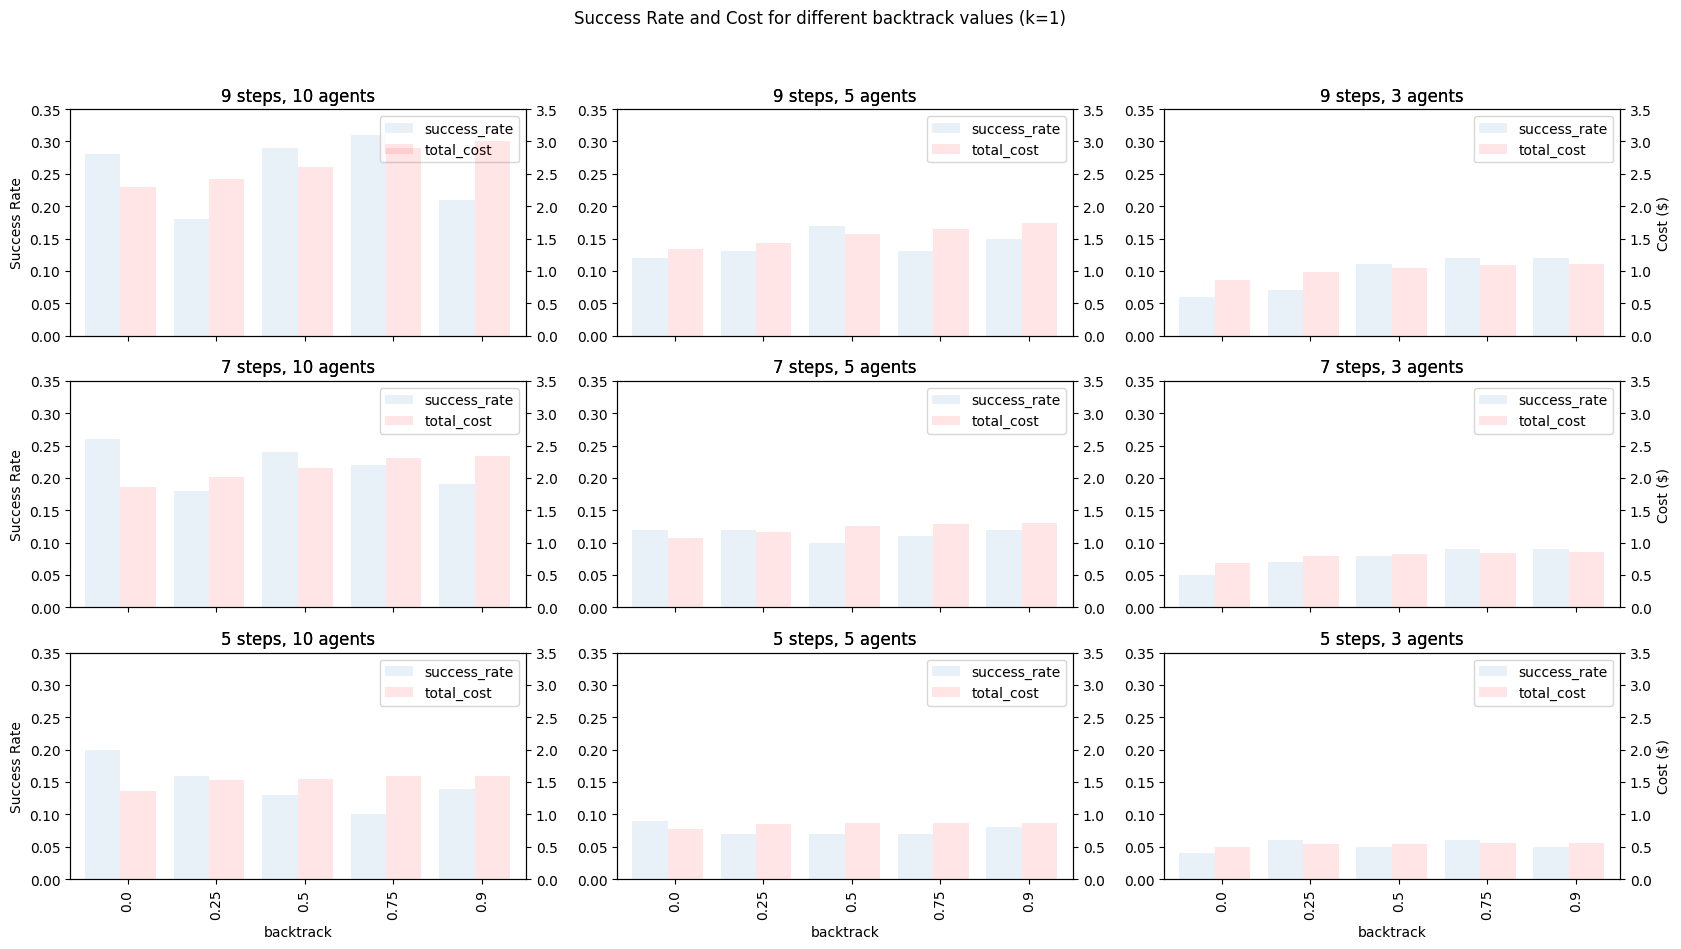

In [104]:
n_steps = df["n_steps"].unique()
n_agents = df["n_agents"].unique()
width = 0.4

temp = df[df.k==1].copy()
temp.sort_values(by=["backtrack"], inplace=True)
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, steps in enumerate(n_steps):
    for j, agents in enumerate(n_agents):
        cost_axis = axes[i,j].twinx()
        temp[(temp.n_steps==steps) & (temp.n_agents==agents)].plot(x="backtrack", y="success_rate", ax=axes[i,j], title=f"{steps} steps, {agents} agents", kind="bar", alpha=0.1, width=-width, position=-width/2)
        temp[(temp.n_steps==steps) & (temp.n_agents==agents)].plot(x="backtrack", y="total_cost", ax=cost_axis, title=f"{steps} steps, {agents} agents", kind="bar", color="red", alpha=0.1, width=width, position=width/2)
        axes[i,j].set_ylim(0, 0.35)
        axes[i,j].set_xlim(-0.65, 4.5)
        cost_axis.set_ylim(0, 3.5)

        # Combining legends
        lines, labels = axes[i,j].get_legend_handles_labels()
        lines2, labels2 = cost_axis.get_legend_handles_labels()
        axes[i,j].legend(lines + lines2, labels + labels2, loc="best")
        cost_axis.legend().remove()
        if i!=2:
            axes[i,j].set_xticklabels([])
            axes[i,j].set_xlabel("")
        
        if j==0:
            axes[i,j].set_ylabel("Success Rate")
        
        if j==2:
            cost_axis.set_ylabel("Cost ($)")

plt.suptitle("Success Rate and Cost for different backtrack values (k=1)")
plt.savefig("pics/gridsearch.png")
plt.show()